In [11]:
#如果你关心事件发生的时间：
#使用 AFT 模型
#如果你关心特征对风险的影响：
#使用 CPH 模型
#如果你只关心生存概率的分布：
#使用 KMF
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [15]:
##导入intro处理后的csv文件，并转换成pandas dataframe以进行后续的处理
from pyspark.sql import SparkSession
from pyspark import SparkConf
conf = SparkConf().setAppName("Project Q2").set("spark.jars", "/data/lab/mysql-connector-j-8.4.0.jar")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

silver_path = "Q2_tries/silver_data.csv"
telco_pd = spark.read.format('csv').option('header','true').load(silver_path).toPandas()

In [16]:
##把选中的列转换为独热变量，将分类变量的各个类拆分成不同列，类型为True，False判断
encode_cols = ['dependents','internetService','onlineBackup','techSupport','paperlessBilling']

encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)

,customerID,gender,seniorCitizen,partner,tenure,phoneService,multipleLines,onlineSecurity,deviceProtection,streamingTV,...,dependents_No,dependents_Yes,internetService_DSL,internetService_Fiber optic,onlineBackup_No,onlineBackup_Yes,techSupport_No,techSupport_Yes,paperlessBilling_No,paperlessBilling_Yes
0,7590-VHVEG,Female,0.0,Yes,1.0,No,No phone service,No,No,No,...,True,False,True,False,False,True,True,False,False,True
1,3668-QPYBK,Male,0.0,No,2.0,Yes,No,Yes,No,No,...,True,False,True,False,False,True,True,False,False,True
2,9237-HQITU,Female,0.0,No,2.0,Yes,No,No,No,No,...,True,False,False,True,True,False,True,False,False,True
3,9305-CDSKC,Female,0.0,No,8.0,Yes,Yes,No,Yes,Yes,...,True,False,False,True,True,False,True,False,False,True
4,1452-KIOVK,Male,0.0,No,22.0,Yes,Yes,No,No,Yes,...,False,True,False,True,False,True,True,False,False,True


In [17]:
##提取需要的列，用于后续分析
survival_pd = encoded_pd[['churn','tenure','dependents_Yes','internetService_DSL','onlineBackup_Yes','techSupport_Yes']]
survival_pd.loc[:,'churn'] = survival_pd.loc[:,'churn'].astype('float')

##拟合cph风险模型
cph = CoxPHFitter(alpha=0.05)
cph.fit(survival_pd, 'tenure', 'churn')
print(cph.print_summary())

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 3351
number of events observed = 1556
   partial log-likelihood = -11178.40
         time fit was run = 2025-04-11 16:16:59 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
dependents_Yes      -0.10      0.90      0.07           -0.24            0.03                0.79                1.03
internetService_DSL -0.04      0.96      0.06           -0.15            0.07                0.86                1.07
onlineBackup_Yes    -0.35      0.71      0.06           -0.46           -0.23                0.63                0.79
techSupport_Yes     -0.21      0.81      0.07           -0.34           -0.08                0.71                0.92

                     cmp to     z      p  -log2(p)
covariate                                         
dependents_Yes         0.00 -1.52   0.13      2.95
internetService_DSL    0.00 -0.78   0.44      1.19
onlineBackup_Yes       0.00 -6.06 <0.005     29.49
techSupport_Yes        0.00 -3.11 <0.005      9.06
---
Concordance = 0.64
Partial AIC = 22364.80
log-likelihood ratio test = 57.57 on 4 df
-log2(p) of ll-ratio test = 36.63

None


In [57]:
##定义一个方法获取用户数据
def get_user_input():
    user_data = {
        'dependents_Yes': int(input("dependents_Yes (0 or 1): ") or 0),
        'internetService_DSL': int(input("internetService_DSL (0 or 1): ") or 0),
        'onlineBackup_Yes': int(input("onlineBackup_Yes (0 or 1): ") or 0),
        'techSupport_Yes': int(input("techSupport_Yes (0 or 1): ") or 0),
        'partner_Yes': int(input("partner_Yes (0 or 1): ") or 0),
        'internal rate of return': float(input("internal rate of return (e.g., 0.10 for 10%): ") or 0.10)
    }
    return pd.DataFrame([user_data])
##设置一个逻辑保存输入的用户数据
user_data = get_user_input()
def get_payback_df():
  df = user_data
  irr = df['internal rate of return'].astype('float64')[0]/12
  cohort_df = pd.concat([pd.DataFrame([1.00]),round(cph.predict_survival_function(df),2)]).rename(columns={0:'Survival Probability'})
  cohort_df['Contract Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Profit for the Selected Plan'] = 30
  cohort_df['Avg Expected Monthly Profit'] = round(cohort_df['Survival Probability'] * cohort_df['Monthly Profit for the Selected Plan'],2)
  cohort_df['NPV of Avg Expected Monthly Profit'] = round(cohort_df['Avg Expected Monthly Profit'] / ((1+irr)**cohort_df['Contract Month']),2)
  cohort_df['Cumulative NPV'] = cohort_df['NPV of Avg Expected Monthly Profit'].cumsum()
  cohort_df['Contract Month'] = cohort_df['Contract Month'] + 1
  return cohort_df[['Contract Month','Survival Probability','Monthly Profit for the Selected Plan','Avg Expected Monthly Profit','NPV of Avg Expected Monthly Profit','Cumulative NPV']].set_index('Contract Month')
##这里是试用一下get_payback_of方法，只显示前25行
pd.options.display.max_rows = 25
get_payback_df()[0:25]

dependents_Yes (0 or 1):  1
internetService_DSL (0 or 1):  0
onlineBackup_Yes (0 or 1):  1
techSupport_Yes (0 or 1):  0
partner_Yes (0 or 1):  1
internal rate of return (e.g., 0.10 for 10%):  0.66


,Survival Probability,Monthly Profit for the Selected Plan,Avg Expected Monthly Profit,NPV of Avg Expected Monthly Profit,Cumulative NPV
Contract Month,,,,,
1,1.00,30,30.0,30.00,30.00
2,0.93,30,27.9,26.45,56.45
3,0.90,30,27.0,24.26,80.71
4,0.88,30,26.4,22.48,103.19
5,0.86,30,25.8,20.83,124.02
6,0.84,30,25.2,19.28,143.30
7,0.83,30,24.9,18.06,161.36
8,0.82,30,24.6,16.91,178.27
9,0.81,30,24.3,15.83,194.10


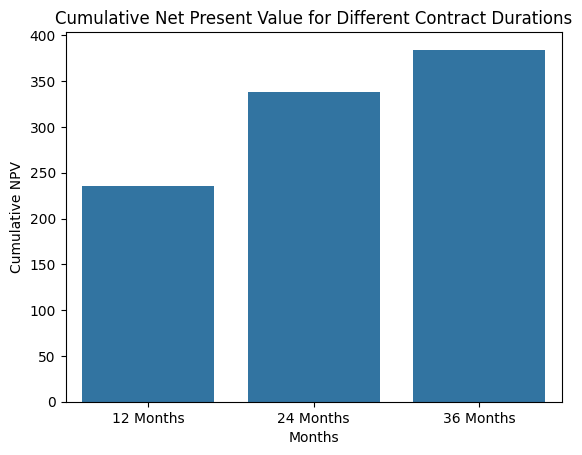

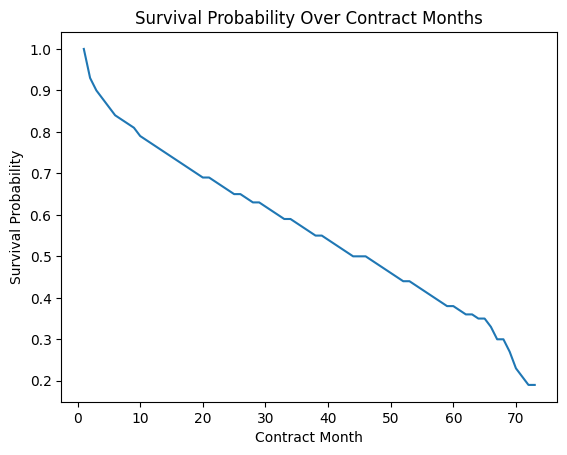

In [60]:
##绘制（指定）不同合同期限的累计净现值和生存概率随合同月份的变化图
import seaborn as sns

sns.barplot(x=['12 Months', '24 Months', '36 Months'], y=get_payback_df().iloc[[11, 23, 35], :]['Cumulative NPV'].values)
plt.xlabel('Months')
plt.ylabel('Cumulative NPV')
plt.title('Cumulative Net Present Value for Different Contract Durations')
plt.show()

sns.lineplot(x=get_payback_df().index, y=get_payback_df()['Survival Probability'])
plt.xlabel('Contract Month')
plt.ylabel('Survival Probability')
plt.title('Survival Probability Over Contract Months')
plt.show()